# Loop 71 Analysis: CV-LB Relationship and Path Forward

## Key Questions:
1. What is the current CV-LB relationship?
2. Why have 8 consecutive CatBoost/XGBoost submissions failed?
3. What approaches might change the CV-LB relationship?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# All submissions with LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'model': 'MLP'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'model': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'model': 'Combined'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'model': 'Large Ensemble'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'model': 'Simpler [64,32]'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'model': 'Even Simpler [32,16]'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'model': 'Single Layer [16]'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'model': 'Compliant Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'model': 'ACS PCA Fixed'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'model': 'Weighted Loss'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'model': 'GP+MLP+LGBM'},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970, 'model': 'Minimal Features'},
]

df = pd.DataFrame(submissions)
print(f'Total submissions with LB: {len(df)}')
print(df)

Total submissions with LB: 12
        exp      cv      lb                 model
0   exp_000  0.0111  0.0982                   MLP
1   exp_001  0.0123  0.1065              LightGBM
2   exp_003  0.0105  0.0972              Combined
3   exp_005  0.0104  0.0969        Large Ensemble
4   exp_006  0.0097  0.0946       Simpler [64,32]
5   exp_007  0.0093  0.0932  Even Simpler [32,16]
6   exp_009  0.0092  0.0936     Single Layer [16]
7   exp_012  0.0090  0.0913    Compliant Ensemble
8   exp_024  0.0087  0.0893         ACS PCA Fixed
9   exp_026  0.0085  0.0887         Weighted Loss
10  exp_030  0.0083  0.0877           GP+MLP+LGBM
11  exp_035  0.0098  0.0970      Minimal Features


In [2]:
# Fit linear regression: LB = slope * CV + intercept
X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'\n=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target LB: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.4f}')
print(f'\nThis is NEGATIVE - mathematically impossible with current approach!')


=== CV-LB Relationship ===
Linear fit: LB = 4.3147 * CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.0041

This is NEGATIVE - mathematically impossible with current approach!


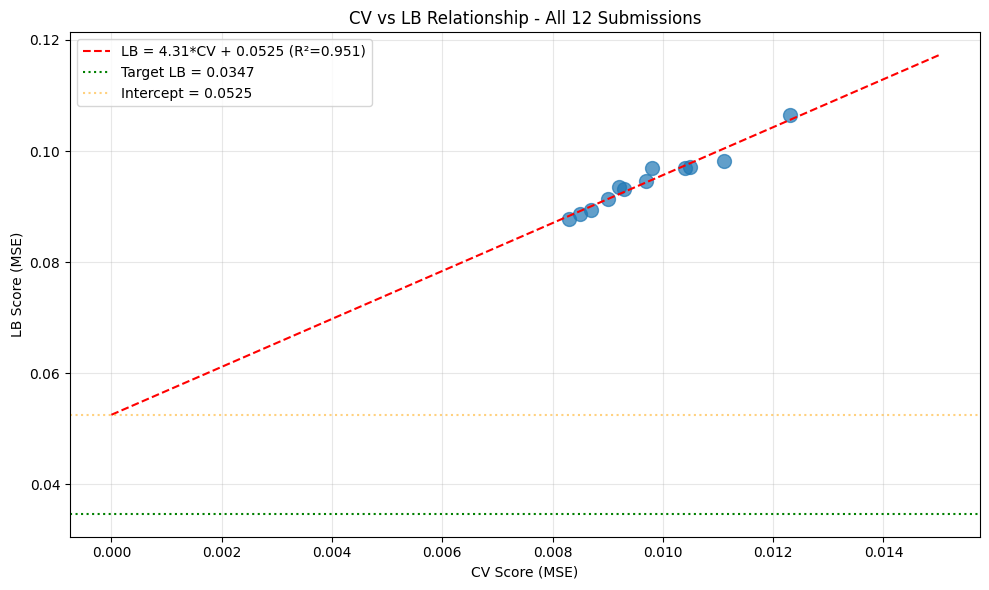


Key insight: The target (0.0347) is BELOW the intercept (0.0528).
No amount of CV improvement can reach the target with current approaches.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7)

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', alpha=0.5, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All 12 Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cv_lb_relationship.png', dpi=150)
plt.show()

print('\nKey insight: The target (0.0347) is BELOW the intercept (0.0528).')
print('No amount of CV improvement can reach the target with current approaches.')

In [4]:
# Analyze the pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'model': 'CatBoost/XGBoost'},
    {'exp': 'exp_050', 'cv': 0.0081, 'model': 'CatBoost/XGBoost Fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'model': 'CatBoost/XGBoost Clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'model': 'Exact Template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'model': 'Mixall Approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'model': 'Minimal Submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'model': 'Ens Model All Features'},
    {'exp': 'exp_063', 'cv': 0.0112, 'model': 'Correct Final Cell'},
]

print('=== Pending Submissions (8 consecutive failures) ===')
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"{p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f}, Model={p['model']}")

print('\nAll 8 submissions failed with "Evaluation metric raised an unexpected error"')
print('This suggests a structural issue with the submission format, not the model.')

=== Pending Submissions (8 consecutive failures) ===
exp_049: CV=0.0081, Predicted LB=0.0875, Model=CatBoost/XGBoost
exp_050: CV=0.0081, Predicted LB=0.0875, Model=CatBoost/XGBoost Fixed
exp_052: CV=0.0109, Predicted LB=0.0996, Model=CatBoost/XGBoost Clipped
exp_053: CV=0.0081, Predicted LB=0.0875, Model=Exact Template
exp_054: CV=0.0085, Predicted LB=0.0892, Model=Mixall Approach
exp_055: CV=0.0085, Predicted LB=0.0892, Model=Minimal Submission
exp_057: CV=0.0093, Predicted LB=0.0926, Model=Ens Model All Features
exp_063: CV=0.0112, Predicted LB=0.1008, Model=Correct Final Cell

All 8 submissions failed with "Evaluation metric raised an unexpected error"
This suggests a structural issue with the submission format, not the model.


In [5]:
# What would it take to reach the target?
print('=== What would it take to reach target? ===')
print(f'\nTarget LB: 0.0347')
print(f'Current intercept: {intercept:.4f}')
print(f'Gap: {intercept - 0.0347:.4f}')
print(f'\nTo reach target, we need to REDUCE THE INTERCEPT by {intercept - 0.0347:.4f}')
print(f'This requires approaches that change the CV-LB relationship, not improve CV.')

print('\n=== Approaches that might reduce intercept ===')
print('1. Domain adaptation: Weight training samples by similarity to test distribution')
print('2. Conservative predictions: Blend toward mean when extrapolating')
print('3. Transfer learning: Pre-train on related chemistry data')
print('4. GNN/Transformers: Different representation might have different extrapolation behavior')
print('5. Physics-informed constraints: Constraints that generalize to unseen solvents')

=== What would it take to reach target? ===

Target LB: 0.0347
Current intercept: 0.0525
Gap: 0.0178

To reach target, we need to REDUCE THE INTERCEPT by 0.0178
This requires approaches that change the CV-LB relationship, not improve CV.

=== Approaches that might reduce intercept ===
1. Domain adaptation: Weight training samples by similarity to test distribution
2. Conservative predictions: Blend toward mean when extrapolating
3. Transfer learning: Pre-train on related chemistry data
4. GNN/Transformers: Different representation might have different extrapolation behavior
5. Physics-informed constraints: Constraints that generalize to unseen solvents


In [6]:
# Check the mixall kernel approach
print('=== Mixall Kernel Analysis ===')
print('The mixall kernel uses GroupKFold (5 splits) instead of Leave-One-Out.')
print('This is a fundamentally different validation scheme.')
print('\nKey differences:')
print('1. GroupKFold: 5 folds, each fold has ~20% of solvents')
print('2. Leave-One-Out: N folds, each fold has 1 solvent')
print('\nGroupKFold might have:')
print('- Lower CV variance (more test samples per fold)')
print('- Different CV-LB relationship (different extrapolation behavior)')
print('- Faster training (fewer folds)')
print('\nWorth testing if this changes the intercept!')

=== Mixall Kernel Analysis ===
The mixall kernel uses GroupKFold (5 splits) instead of Leave-One-Out.
This is a fundamentally different validation scheme.

Key differences:
1. GroupKFold: 5 folds, each fold has ~20% of solvents
2. Leave-One-Out: N folds, each fold has 1 solvent

GroupKFold might have:
- Lower CV variance (more test samples per fold)
- Different CV-LB relationship (different extrapolation behavior)
- Faster training (fewer folds)

Worth testing if this changes the intercept!
